# Prétraitement des Données

Price cap (99th percentile): 5,000,000 RUB
Price cap (99th percentile): nan RUB


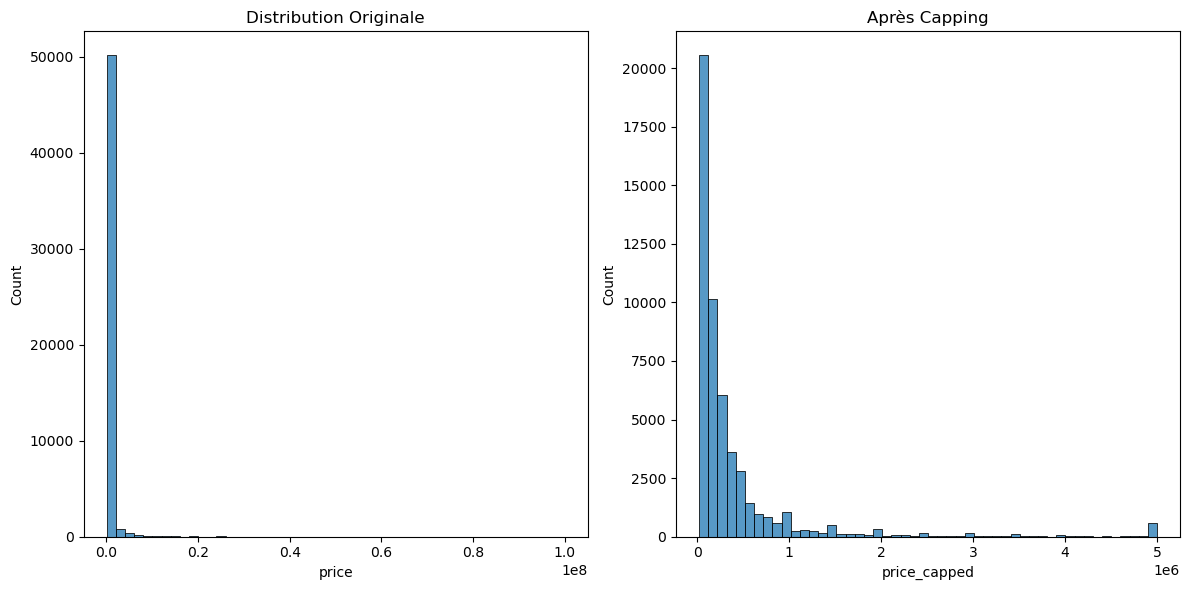

In [2]:
# Prétraitement des Données

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


# Chargement des données
data_path = Path("C:/Users/Optimiste/Videos/Concours/Prédiction_prix_plaques_russes/data")
train = pd.read_csv(data_path / "train_processed.csv")
test = pd.read_csv(data_path / "test_processed.csv")

## 1. Gestion des Outliers
# Calcul du cap à 99%
price_cap = train['price'].quantile(0.99)     # 1% des plaques les plus chères seront considérées comme outliers.
print(f"Price cap (99th percentile): {price_cap:,.0f} RUB") # price_cap est donc une valeur limite au-delà de laquelle on va tronquer les prix.

# Application du capping
train['price_capped'] = np.where(train['price'] > price_cap, price_cap, train['price'])

# Si le prix est supérieur au seuil, on le remplace par price_cap. Sinon, on garde le prix initial.

## Test
price_cap = test['price'].quantile(0.99)     # 1% des plaques les plus chères seront considérées comme outliers.
print(f"Price cap (99th percentile): {price_cap:,.0f} RUB") # price_cap est donc une valeur limite au-delà de laquelle on va tronquer les prix.

# Application du capping
test['price_capped'] = np.where(test['price'] > price_cap, price_cap, test['price'])



# Visualisation avant/après
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.histplot(train['price'], bins=50)
plt.title('Distribution Originale')
plt.subplot(122)
sns.histplot(train['price_capped'], bins=50)
plt.title('Après Capping')
plt.tight_layout()
plt.show()

Le résultat du capping montre que le 99e percentile du prix est de **5 000 000 RUB**. Cela signifie que :

📌 Interprétation :
- **99 %** des plaques sont vendues en dessous de **5 millions RUB**
- Les **1 %** restants (≈ **516 lignes**) sont considérés comme des **outliers**

Tu viens de réduire leur influence sur l'entraînement du modèle sans les supprimer

---
### 1. Transformation des Variables

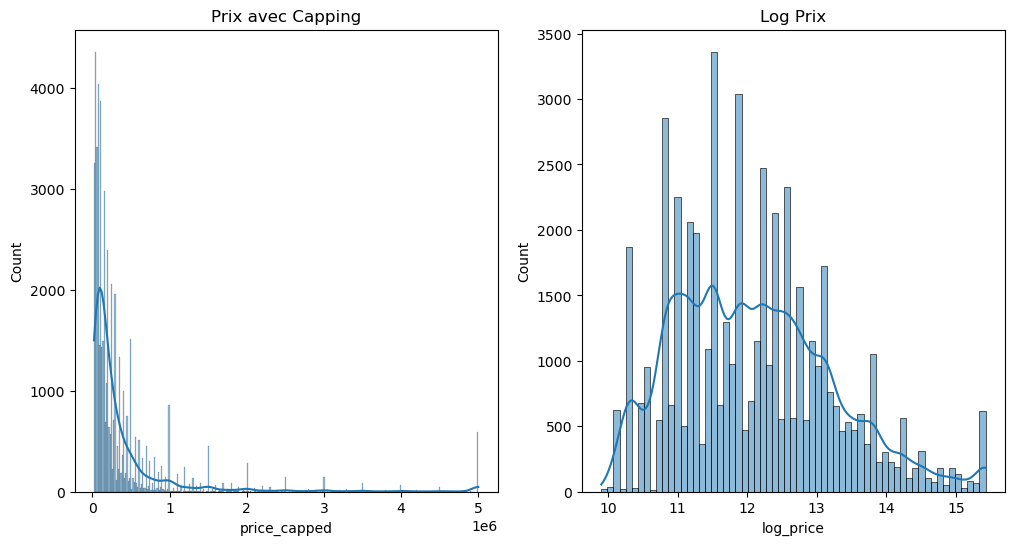

In [5]:
#  Transformation Logarithmique
# Application du log(1 + x)
train['log_price'] = np.log1p(train['price_capped'])

# Test
test['log_price'] = np.log1p(test['price_capped'])

# Vérification
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(train['price_capped'], ax=ax[0], kde=True)
ax[0].set_title('Prix avec Capping')
sns.histplot(train['log_price'], ax=ax[1], kde=True)
ax[1].set_title('Log Prix')
plt.show()

##### 🔎 Analyse du graphique

##### 📈 **Graphe de gauche : price_capped**

* Distribution très **asymétrique**, fortement **concentrée vers les bas prix**.
* Même après capping à 5M, il reste un effet « longue traîne ».
* ➕ Bien d’avoir conservé les données avec le capping au lieu de les supprimer.

##### 🔢 **Graphe de droite : `log_price`**

* Distribution transformée est **beaucoup plus normale**
* Pic vers `log_price` ≈ **11.5–12.5**, soit un prix réel entre **100 000 et 270 000 RUB**
* C’est une excellente **base pour un modèle de régression** (surtout linéaire ou arbre boosté)


---
### 2. Encodage des régions

In [13]:
# Gestion des Régions

# Fréquences des régions
region_counts = train['region_name'].value_counts()
region_counts = test['region_name'].value_counts()

# Régions peu fréquentes (< 50 occurrences)
rare_regions = region_counts[region_counts < 50].index
print(f"{len(rare_regions)} régions rares détectées")

rare_regions = region_counts[region_counts < 50].index
print(f"{len(rare_regions)} régions test rares détectées")

# Regroupement
train['region_processed'] = np.where(
    train['region_name'].isin(rare_regions),
    'RARE_REGION',
    train['region_name']
)

test['region_processed'] = np.where(
    test['region_name'].isin(rare_regions),
    'RARE_REGION',
    test['region_name']
)


73 régions rares détectées
73 régions test rares détectées


In [15]:

# Encodage
le = LabelEncoder()
combined_regions = pd.concat([train['region_processed'], test['region_processed']], axis=0)
le.fit(combined_regions)

train['region_encoded'] = le.transform(train['region_processed'])
test['region_encoded'] = le.transform(test['region_processed'])

# Vérification
print("\nExemple d'encodage :")
print(train[['region_name', 'region_processed', 'region_encoded']].drop_duplicates().head(10))


Exemple d'encodage :
             region_name      region_processed  region_encoded
0                 Moscow                Moscow               5
1          Moscow Oblast         Moscow Oblast               6
15  Republic of Dagestan  Republic of Dagestan               9
17        Irkutsk Oblast           RARE_REGION               8
19      Volgograd Oblast           RARE_REGION               8
24     Sverdlovsk Oblast     Sverdlovsk Oblast              14
26        Krasnodar Krai        Krasnodar Krai               3
27      Saint Petersburg      Saint Petersburg              12
31      Zabaykalsky Krai           RARE_REGION               8
35         Kaluga Oblast           RARE_REGION               8


In [17]:
## Encodage des Saisons

season_map = {'winter':0, 'spring':1, 'summer':2, 'fall':3}
train['season_encoded'] = train['season'].map(season_map)
test['season_encoded'] = test['season'].map(season_map)

---
### 3. Standardisation des Variables Numériques

In [20]:
#  Standardisation
from sklearn.preprocessing import StandardScaler

# Colonnes à standardiser
num_features = ['digits', 'plate_age_days']

scaler = StandardScaler()
train[num_features] = scaler.fit_transform(train[num_features])
test[num_features] = scaler.transform(test[num_features])

# Vérification
print("\nStatistiques après standardisation :")
print(train[num_features].describe().loc[['mean', 'std']])


Statistiques après standardisation :
            digits  plate_age_days
mean  1.981566e-17    4.183306e-17
std   1.000010e+00    1.000010e+00


---
### 4. Feature Engineering Complémentaire

In [23]:
# Dérivation de Nouvelles Variables
# Interaction région + premium
moscow_code = le.transform(['Moscow'])[0]
spb_code = le.transform(['Saint Petersburg'])[0]

train['premium_region'] = (
    train['premium_plate'] & train['region_encoded'].isin([moscow_code, spb_code])
).astype(int)

test['premium_region'] = (
    test['premium_plate'] & test['region_encoded'].isin([moscow_code, spb_code])
).astype(int)



# Âge de la plaque en mois
train['plate_age_months'] = train['plate_age_days'] // 30
test['plate_age_months'] = test['plate_age_days'] // 30

---
### 5. Sauvegarde des Données

In [26]:
# Export Final

final_features = [
    'id', 'plate', 'date',
    # Variables cibles
    'log_price', 'price_capped', 'price', 
    # Features
    'digits', 'letters', 
    'region_encoded', 'season_encoded',
    'is_gov_plate', 'premium_plate',
    'plate_age_days', 'plate_age_months',
    'premium_region'
]

# Sauvegarde
train[final_features].to_csv(data_path / "train_preprocessed_v2.csv", index=False)
test[final_features].to_csv(data_path / "test_preprocessed_v2.csv", index=False)

# Sauvegarde des encodeurs
import joblib
joblib.dump({
    'label_encoder': le,
    'scaler': scaler,
    'season_map': season_map,
    'price_cap': price_cap
}, data_path / "preprocessors.joblib")

print(f"""
✅ Prétraitement terminé !
- Fichiers sauvegardés : 
  * train_preprocessed_v2.csv ({len(train)} lignes)
  * test_preprocessed_v2.csv ({len(test)} lignes)
- Encodeurs sauvegardés : preprocessors.joblib
""")


✅ Prétraitement terminé !
- Fichiers sauvegardés : 
  * train_preprocessed_v2.csv (51635 lignes)
  * test_preprocessed_v2.csv (7695 lignes)
- Encodeurs sauvegardés : preprocessors.joblib

